In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings

# تنظیمات اولیه
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')


In [5]:

class MovieRecommender:
    """
    A comprehensive movie recommendation system with content-based, user-based, and item-based collaborative filtering.
    
    Parameters:
    - movies_path: Path to movies CSV file
    - ratings_path: Path to ratings CSV file
    - k_neighbors: Number of neighbors for collaborative filtering
    - min_ratings: Minimum number of ratings a movie must have to be considered
    - test_size: Proportion of data to use for testing
    """
    
    def __init__(self, movies_path='movies.csv', ratings_path='ratings.csv', 
                 k_neighbors=5, min_ratings=10, test_size=0.1):
        self.k_neighbors = k_neighbors
        self.min_ratings = min_ratings
        self.test_size = test_size
        
        # Load and preprocess data
        self.load_data(movies_path, ratings_path)
        self.preprocess_data()
        self.prepare_recommendation_models()
    
    def load_data(self, movies_path, ratings_path):
        """Load and inspect the raw data."""
        self.movies = pd.read_csv(movies_path)
        self.ratings = pd.read_csv(ratings_path)
        
        print("Data loaded successfully:")
        print(f"- Movies: {self.movies.shape[0]} records")
        print(f"- Ratings: {self.ratings.shape[0]} records")
        print("\nMissing values:")
        print("Movies:", self.movies.isnull().sum().to_string())
        print("\nRatings:", self.ratings.isnull().sum().to_string())
    
    def preprocess_data(self):
        """Clean and prepare data for analysis."""
        # Convert genres to list
        self.movies['genres'] = self.movies['genres'].str.split('|')
        
        # Convert timestamp
        self.ratings['timestamp'] = pd.to_datetime(self.ratings['timestamp'], unit='s')
        
        # Filter movies with sufficient ratings
        rating_counts = self.ratings['movieId'].value_counts()
        popular_movies = rating_counts[rating_counts >= self.min_ratings].index
        self.ratings = self.ratings[self.ratings['movieId'].isin(popular_movies)]
        
        # Create genre string for TF-IDF
        self.movies['genres_str'] = self.movies['genres'].apply(lambda x: ' '.join(x))
    
    def prepare_recommendation_models(self):
        """Prepare all required models and similarity matrices."""
        # Content-based model
        self.prepare_content_based_model()
        
        # Collaborative filtering models
        self.prepare_collaborative_filtering_models()
    
    def prepare_content_based_model(self):
        """Prepare TF-IDF and cosine similarity for content-based recommendations."""
        tfidf = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = tfidf.fit_transform(self.movies['genres_str'])
        self.content_cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
        self.content_indices = pd.Series(self.movies.index, index=self.movies['title']).drop_duplicates()
    
    def prepare_collaborative_filtering_models(self):
        """Prepare user-item matrix and similarity matrices for collaborative filtering."""
        # Create sparse user-movie matrix
        user_movie = self.ratings.pivot_table(
            index='userId', 
            columns='movieId', 
            values='rating',
            fill_value=0
        )
        
        # Convert to sparse matrix for efficiency
        self.user_movie_sparse = csr_matrix(user_movie.values)
        
        # Calculate similarities
        print("\nCalculating user similarities...")
        self.user_similarity = cosine_similarity(self.user_movie_sparse)
        
        print("Calculating item similarities...")
        self.movie_similarity = cosine_similarity(self.user_movie_sparse.T)
        
        # Store mapping indices
        self.user_ids = user_movie.index
        self.movie_ids = user_movie.columns
        
        # Create DataFrame mappings
        self.user_sim_df = pd.DataFrame(
            self.user_similarity,
            index=self.user_ids,
            columns=self.user_ids
        )
        
        self.movie_sim_df = pd.DataFrame(
            self.movie_similarity,
            index=self.movie_ids,
            columns=self.movie_ids
        )
    
    def content_based_recommendations(self, title, n=10):
        """
        Get content-based recommendations using genre similarity.
        
        Args:
            title: Movie title to find similar movies for
            n: Number of recommendations to return
            
        Returns:
            DataFrame with recommended movies and similarity scores
        """
        try:
            idx = self.content_indices[title]
            sim_scores = list(enumerate(self.content_cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
            movie_indices = [i[0] for i in sim_scores]
            
            recommendations = self.movies.iloc[movie_indices][['title', 'genres']]
            recommendations['similarity'] = [i[1] for i in sim_scores]
            
            return recommendations
        except KeyError:
            print(f"Movie '{title}' not found in database.")
            return pd.DataFrame()
    
    def user_based_recommendations(self, user_id, n=10):
        """
        Get recommendations for a user based on similar users' preferences.
        
        Args:
            user_id: ID of the user to get recommendations for
            n: Number of recommendations to return
            
        Returns:
            DataFrame with recommended movies and predicted ratings
        """
        if user_id not in self.user_sim_df.index:
            print(f"User ID {user_id} not found.")
            return pd.DataFrame()
        
        # Get similar users
        similar_users = self.user_sim_df[user_id].sort_values(ascending=False)[1:self.k_neighbors+1]
        
        # Get movies not rated by the user
        user_ratings = self.user_movie_sparse[self.user_ids.get_loc(user_id)]
        unseen_mask = user_ratings.toarray().flatten() == 0
        unseen_movies = self.movie_ids[unseen_mask]
        
        # Calculate weighted ratings
        movie_scores = []
        for movie_id in unseen_movies:
            movie_idx = self.movie_ids.get_loc(movie_id)
            similar_users_ratings = self.user_movie_sparse[
                [self.user_ids.get_loc(u) for u in similar_users.index], 
                movie_idx
            ].toarray().flatten()
            
            # Only consider users who have rated the movie
            valid_ratings_mask = similar_users_ratings != 0
            if np.any(valid_ratings_mask):
                weighted_avg = np.dot(
                    similar_users_ratings[valid_ratings_mask],
                    similar_users.values[valid_ratings_mask]
                ) / np.sum(similar_users.values[valid_ratings_mask])
                
                movie_scores.append((movie_id, weighted_avg))
        
        # Return top recommendations
        if movie_scores:
            recommendations = pd.DataFrame(
                sorted(movie_scores, key=lambda x: x[1], reverse=True)[:n],
                columns=['movieId', 'predicted_rating']
            )
            return recommendations.merge(self.movies, on='movieId')[['title', 'genres', 'predicted_rating']]
        else:
            print("No recommendations available.")
            return pd.DataFrame()
    
    def item_based_recommendations(self, movie_title, n=10):
        """
        Get recommendations based on item similarity.
        
        Args:
            movie_title: Title of the movie to find similar items for
            n: Number of recommendations to return
            
        Returns:
            DataFrame with similar movies and similarity scores
        """
        try:
            movie_id = self.movies[self.movies['title'] == movie_title]['movieId'].values[0]
            similar_movies = self.movie_sim_df[movie_id].sort_values(ascending=False)[1:n+1]
            
            recommendations = similar_movies.reset_index()
            recommendations.columns = ['movieId', 'similarity_score']
            return recommendations.merge(self.movies, on='movieId')[['title', 'genres', 'similarity_score']]
        except IndexError:
            print(f"Movie '{movie_title}' not found in database.")
            return pd.DataFrame()
    
    def predict_rating(self, user_id, movie_id):
        """
        Predict a user's rating for a specific movie.
        
        Args:
            user_id: ID of the user
            movie_id: ID of the movie
            
        Returns:
            Predicted rating or None if prediction not possible
        """
        try:
            if user_id not in self.user_sim_df.index or movie_id not in self.movie_sim_df.index:
                return None
                
            # Get similar users
            similar_users = self.user_sim_df[user_id].sort_values(ascending=False)[1:self.k_neighbors+1]
            
            # Get ratings from similar users
            movie_idx = self.movie_ids.get_loc(movie_id)
            similar_users_ratings = self.user_movie_sparse[
                [self.user_ids.get_loc(u) for u in similar_users.index], 
                movie_idx
            ].toarray().flatten()
            
            # Calculate weighted average
            valid_ratings_mask = similar_users_ratings != 0
            if np.any(valid_ratings_mask):
                weighted_avg = np.dot(
                    similar_users_ratings[valid_ratings_mask],
                    similar_users.values[valid_ratings_mask]
                ) / np.sum(similar_users.values[valid_ratings_mask])
                return weighted_avg
            return None
        except Exception as e:
            print(f"Error predicting rating: {str(e)}")
            return None
    
    def evaluate(self):
        """Evaluate the recommendation system using RMSE."""
        test_data = self.ratings.sample(frac=self.test_size)
        predictions = []
        
        print("\nEvaluating system on test data...")
        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            pred = self.predict_rating(row['userId'], row['movieId'])
            if pred is not None:
                predictions.append((row['rating'], pred))
        
        if predictions:
            actual, preds = zip(*predictions)
            rmse = np.sqrt(mean_squared_error(actual, preds))
            print(f"\nRecommendation system RMSE: {rmse:.4f}")
            return rmse
        else:
            print("Could not make any valid predictions on test set.")
            return None
    
    def visualize_data(self):
        """Create visualizations of the data distributions."""
        plt.figure(figsize=(15, 5))
        
        # Genre distribution
        plt.subplot(1, 2, 1)
        all_genres = [genre for sublist in self.movies['genres'] for genre in sublist]
        pd.Series(all_genres).value_counts().plot(kind='bar')
        plt.title('Movie Genres Distribution')
        plt.xlabel('Genre')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        # Rating distribution
        plt.subplot(1, 2, 2)
        sns.countplot(x='rating', data=self.ratings)
        plt.title('User Ratings Distribution')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        
        plt.tight_layout()
        plt.show()


Data loaded successfully:
- Movies: 9742 records
- Ratings: 100836 records

Missing values:
Movies: movieId    0
title      0
genres     0

Ratings: userId       0
movieId      0
rating       0
timestamp    0

Calculating user similarities...
Calculating item similarities...


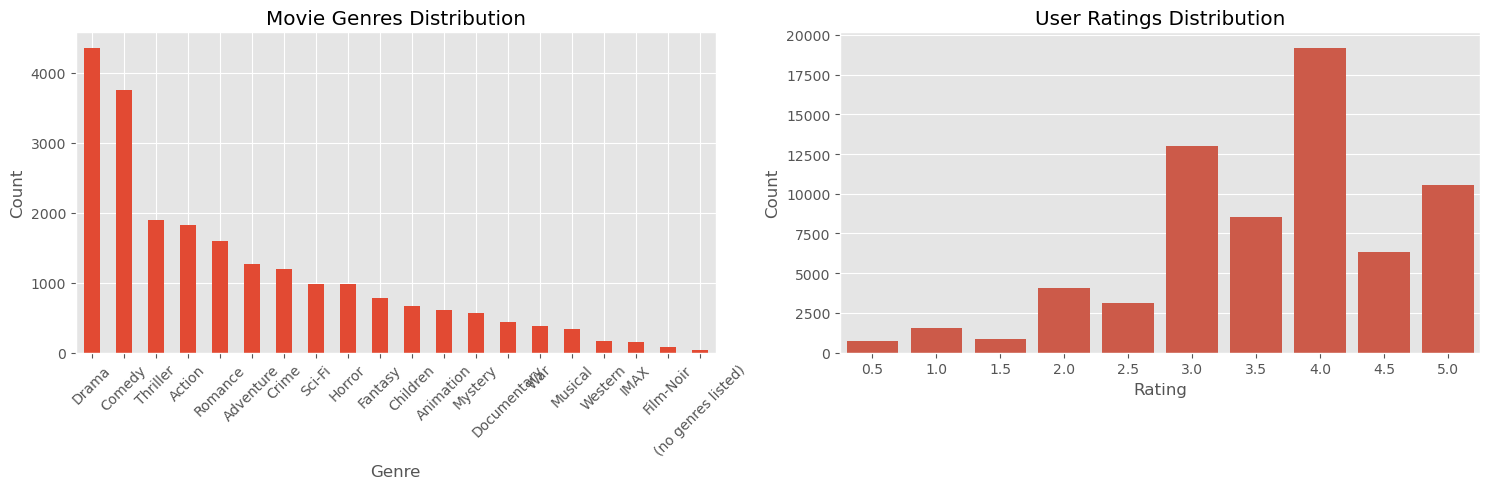


Content-based recommendations for 'Toy Story (1995)':
                                                  title                                            genres  similarity
                                            Antz (1998) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
                                     Toy Story 2 (1999) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
         Adventures of Rocky and Bullwinkle, The (2000) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
                       Emperor's New Groove, The (2000) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
                                  Monsters, Inc. (2001) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
                                       Wild, The (2006) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
                                 Shrek the Third (2007) [Adventure, Animation, Children, Comedy, Fantasy]         1.0
 

100%|████████████████████████████████████████████████████████████████████████████| 6790/6790 [00:03<00:00, 2212.57it/s]


Recommendation system RMSE: 0.9976


In [6]:
# Example usage
if __name__ == "__main__":
    # Initialize recommender system
    recommender = MovieRecommender(
        movies_path='movies.csv',
        ratings_path='ratings.csv',
        k_neighbors=5,
        min_ratings=20,
        test_size=0.1
    )
    
    # Show data visualizations
    recommender.visualize_data()
    
    # Get recommendations
    print("\nContent-based recommendations for 'Toy Story (1995)':")
    print(recommender.content_based_recommendations('Toy Story (1995)').to_string(index=False))
    
    print("\nUser-based recommendations for user 1:")
    print(recommender.user_based_recommendations(1).to_string(index=False))
    
    print("\nItem-based recommendations for 'Toy Story (1995)':")
    print(recommender.item_based_recommendations('Toy Story (1995)').to_string(index=False))
    
    # Evaluate system
    recommender.evaluate()